In [1]:
pip install -U notebook-as-pdf

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Exercise 1

#### CIFAR dataset: 10000 images per batch (n = 10000) with dimensionnality of 32x32x3 (d = 3072) belonging to 10 labels (K = 10)
Taking in the CIFAR dataset and extracting files such that we have: 
 - "X": 3072-by-10000 image pixel data 
 - "y": 10-by-1000 label data
 - "Y": 10-by-1000 one-hot encoded label data

In [844]:
def LoadBatch(file):
    X = unpickle(file)[b'data'].T / 255 # Normalised image inputs
    y = unpickle(file)[b'labels'] # Output labels
    Y = one_hot(y) # One hot encoded output labels
    return X, y, Y

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(labels, number_distinct_labels=10):
    labels_one_hot = np.zeros(shape=(number_distinct_labels,len(labels)))
    for i, label in enumerate(labels):
        labels_one_hot[label,i] = 1
    return labels_one_hot

In [845]:
# Training data
X_1, y_1, Y_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
X_2, y_2, Y_2 = LoadBatch('cifar-10-batches-py/data_batch_2')

# Test data
X_t, y_t, Y_t = LoadBatch('cifar-10-batches-py/test_batch')

batches = unpickle('cifar-10-batches-py/batches.meta')

label_names = [label_name.decode('utf-8') for label_name in batches[b'label_names']]
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [846]:
print("Input image matrix "+ str(X_1.shape) + ":")
print(X_1)
print("-----")
print("Output one-hot matrix "+ str(Y_1.shape) + ":")
print(Y_1)

Input image matrix (3072, 10000):
[[0.23137255 0.60392157 1.         ... 0.27843137 0.98039216 0.24313725]
 [0.16862745 0.49411765 0.99215686 ... 0.23529412 0.99607843 0.23921569]
 [0.19607843 0.41176471 0.99215686 ... 0.29019608 0.82745098 0.23529412]
 ...
 [0.54901961 0.54509804 0.3254902  ... 0.26666667 0.84313725 0.50980392]
 [0.32941176 0.55686275 0.3254902  ... 0.27058824 1.         0.50980392]
 [0.28235294 0.56470588 0.32941176 ... 0.26666667 0.99607843 0.51372549]]
-----
Output one-hot matrix (10, 10000):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


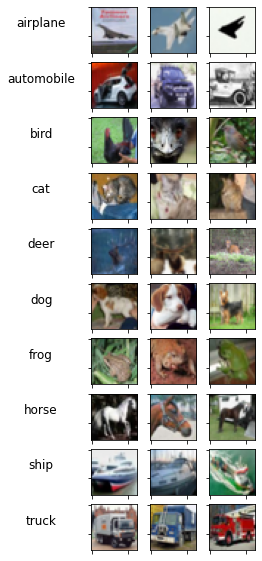

In [847]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(3,10))

for label_idx, label_name in enumerate(label_names):
    X = X_t[:,np.equal(y_t, label_idx)][:,0:3]
    for image_idx, image in enumerate(X.T):
        axes[label_idx][image_idx].imshow(image.reshape(3,32,32).transpose([1,2,0]))
        axes[label_idx][image_idx].tick_params(labelbottom=False, labelleft=False)
    axes[label_idx][0].set_ylabel(label_name, labelpad=50, rotation=0, size='large')

## Exercise 2

#### Preprocessing the data: Compute the mean and standard deviation vector for the training data and then normalize the training, validation and test data w.r.t. these mean and standard deviation vectors.

In [848]:
def preprocess_images(X, mean, std): 
    
    if mean is None and std is None:
        mean = np.mean(X, axis=0)  # Mean of the columns
        std = np.std(X, axis=0)  # Std of the columns
        
    X -= mean
    X /= std
        
    return X, mean, std

In [849]:
X_train, train_mean, train_std = preprocess_images(X_1, mean = None, std = None)
X_val, val_mean, val_std = preprocess_images(X_2, mean = train_mean, std = train_std)
X_test, test_mean, test_std = preprocess_images(X_t, mean = train_mean, std = train_std)

print(np.mean(X_train, axis=0))

[-7.40148683e-17 -4.30211422e-16  2.77555756e-16 ... -7.40148683e-17
 -2.12792746e-16  2.12792746e-16]


In [850]:
print(X_1.shape, X_train.shape)
print(X_2.shape, X_val.shape)
print(X_t.shape, X_test.shape)

(3072, 10000) (3072, 10000)
(3072, 10000) (3072, 10000)
(3072, 10000) (3072, 10000)


## Exercise 3

#### Initializing the weights and biases.
 - W -> K-by-d matrix
 - b -> K-by-1 matrix

In [851]:
def initialize_weights(d, K, seed=42):
    np.random.seed(seed)
    W = np.random.normal(0, 0.01, (K, d))  # Dim: k x d
    b = np.random.normal(0, 0.01, (K, 1))  # Dim: k x 1
    return W, b

In [852]:
# Initializing weight and bias matrix

d = X_1.shape[0] # Number of dimmensions
K = Y_1.shape[0] # Number of classes

W, b = initialize_weights(d, K)

## Exercise 4

#### Evaluating the network using: P = softmax(WX + b), where P is a K-by-N matrix in which each column of P contains the probability for each label for the image in the corresponding column of X.

In [853]:
def softmax(S):
    return np.exp(S) / np.exp(S).sum(axis=0)
    
def EvaluateClassifier(X, W, b):
    return softmax(np.dot(W, X) + b)

In [854]:
subset_size = 100
EvaluateClassifier(X_1[:,0:subset_size], W, b).shape

(10, 100)

## Exercise 5

#### Computing the cost function for cross entropy loss with L2 regularization.

In [855]:
def ComputeCost(X, Y, W, b, λ):
    # Compute network output
    P = EvaluateClassifier(X, W, b)
    # Compute loss function term
    L = sum(-np.log((Y*P).sum(axis=0)))
    # Compute regularization term
    L_λ = λ*(W**2).sum()
    # Compute total cost
    J = L/X.shape[1] + L_λ
    return J

## Exercise 6

#### Computing the accuracy of the network's predictions where accuracy = % of correctly classified images.

In [856]:
def ComputeAccuracy(X, y, W, b):
    # Compute network output
    P = EvaluateClassifier(X, W, b)
    # Compute the accuracy
    acc = np.mean(y==np.argmax(P, 0))
    return acc

## Exercise 7

#### Computing the gradients of the cost function w.r.t W and b analytically.

In [857]:
def ComputeGradients(X, Y, P, W, λ):
    G = -(Y-P)
    grad_W = (np.dot(G, X.T)) / X.shape[1]+2*λ*W
    grad_b = (np.dot(G, np.ones(shape=(X.shape[1],1)))/X.shape[1]).reshape(Y.shape[0],1)
    return grad_W, grad_b

#### Comparing results with gradients computed numerically.

In [859]:
def ComputeGradsNum(X, Y, W, b, lamda, h=0.000001):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));

    c = ComputeCost(X, Y, W, b, lamda);
    
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)
        grad_b[i] = (c2-c) / h

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)
            grad_W[i,j] = (c2-c) / h

    return [grad_W, grad_b]

In [860]:
X = X_1[0:20,[0]]
Y = Y_1[:,[0]]
λ = 0

# Computing the gradients analytically
P = EvaluateClassifier(X, W[:,0:20], b)
grad_W_analytical, grad_b_analytical = ComputeGradients(X, Y, P, W[:,0:20], λ)

# Computing the gradients numerically
grad_W_numerical, grad_b_numerical = ComputeGradsNum(X, Y, W[:,0:20], b, λ)

# Absolute error between both gradients
grad_W_abs_diff = np.abs(grad_W_numerical-grad_W_analytical)
grad_b_abs_diff = np.abs(grad_b_numerical-grad_b_analytical)

w_errors, b_errors = np.mean(grad_W_abs_diff<1e-6)*100, np.mean(grad_b_abs_diff<1e-6)*100
w_max_error, b_max_error = (grad_W_abs_diff).max(), (grad_b_abs_diff).max()

print("Percentage of weight errors < 1e-6:", w_errors)
print("Percentage of bias errors < 1e-6:", b_errors)
print("Max weight error:", w_max_error)
print("Max bias error:", b_max_error)

Percentage of weight errors < 1e-6: 100.0
Percentage of bias errors < 1e-6: 100.0
Max weight error: 6.406758017163394e-08
Max bias error: 4.752002508157105e-08


## Exercise 8

#### Performing the mini-batch gradient descent algorithm to train the model.

In [861]:
# Mini-batch gradient descent algorithm
def MiniBatchGD(X, Y, y, X_val, Y_val, y_val, W, b, GDparams, λ):
    
    n = X.shape[1]
    
    eta = GDparams['eta']
    n_batch = GDparams['n_batch']
    n_epochs = GDparams['n_epochs']
    
    # Creating copy of parameters to be updated
    W = W.copy()
    b = b.copy()
    
    # Measured metrics
    epochs = []
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []
    
    # Mini-batch gradient descent algorithm
    for epoch in tqdm(range(n_epochs)):  
        for j in range(n//n_batch):
            j_start = j*n_batch
            j_end = (j+1)*n_batch
            
            inds = range(j_start, j_end)
            X_batch = X[:,inds]
            Y_batch = Y[:,inds]
            
            # Updating model parameters using computed gradients
            P_batch = EvaluateClassifier(X_batch, W, b)
            grad_W, grad_b = ComputeGradients(X_batch, Y_batch, P_batch, W, λ)
            W -= eta*grad_W
            b -= eta*grad_b
        
        epochs.append(epoch+1)
        loss_train.append(ComputeCost(X, Y, W, b, λ))
        acc_train.append(ComputeAccuracy(X, y, W, b))
        loss_val.append(ComputeCost(X_val, Y_val, W, b, λ))
        acc_val.append(ComputeAccuracy(X_val, y_val, W, b))
        
        print("Epoch "+str(epoch+1)+": loss="+str(loss_train[-1])+", accuracy="+str(acc_train[-1])+"\r")

    return W, b, epochs, loss_train, acc_train, loss_val, acc_val

In [862]:
# Function to plot the loss and accuracy learning curves
def plot_learning_curve(epochs, loss_train, acc_train, loss_val, acc_val):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Loss and accuracy learning curves of the model')
    
    ax1.plot(epochs, loss_train, label = "Training loss", color = "blue")
    ax2.plot(epochs, acc_train, label = "Training accuracy", color = "blue")
    ax1.plot(epochs, loss_val, label = "Validation loss", color = "red")   
    ax2.plot(epochs, acc_val, label = "Validation accuracy", color = "red")
    
    ax1.set_xlabel("Epochs")
    ax2.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    
    ax1.grid(True)
    ax2.grid(True)
    ax1.legend()
    ax2.legend()

In [863]:
# Function to plot and visualize the final weights of the network
def plot_weights(W, label_names):
    
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,2.5))
    plt.suptitle('Visualization of the weight matrix W')
    
    for c, ax in enumerate(axes.flatten()):

        # Getting weights and label associated with each output node
        image = W[c]
        labels = label_names[c]
        
        # Visualising the weights in inmage format
        min_image = min(image)
        max_image = max(image)
        image = (image-min_image)/(max_image-min_image)
        
        ax.imshow(image.reshape(3,32,32).transpose([1,2,0]))
        ax.axis('off')
        ax.set_title(labels)

#### Training the model with 1st set of parameters

In [864]:
# Model parameters 1
GDparams_1 = {'n_batch':100, 'eta':0.1, 'n_epochs':40}
λ_1 = 0

# Training the model
W_1, b_1, epochs_1, loss_train_1, acc_train_1, loss_val_1, acc_val_1 = MiniBatchGD(X = X_train, Y = Y_1, y = y_1, 
                                                                            X_val = X_val, Y_val = Y_2, y_val = y_2,
                                                                            W = W, b = b, GDparams = GDparams_1, λ = λ_1)

  2%|▎         | 1/40 [00:00<00:12,  3.15it/s]

Epoch 1: loss=3.9852341188156766, accuracy=0.2895


  5%|▌         | 2/40 [00:00<00:11,  3.33it/s]

Epoch 2: loss=3.8772682831969694, accuracy=0.3001


  8%|▊         | 3/40 [00:00<00:10,  3.45it/s]

Epoch 3: loss=3.609030668695634, accuracy=0.3272


 10%|█         | 4/40 [00:01<00:10,  3.40it/s]

Epoch 4: loss=3.5510438833782123, accuracy=0.342


 12%|█▎        | 5/40 [00:01<00:09,  3.51it/s]

Epoch 5: loss=3.3797929993137297, accuracy=0.3565


 15%|█▌        | 6/40 [00:01<00:09,  3.59it/s]

Epoch 6: loss=3.3583921090214295, accuracy=0.3471


 18%|█▊        | 7/40 [00:02<00:09,  3.57it/s]

Epoch 7: loss=3.3919536331395967, accuracy=0.3563


 20%|██        | 8/40 [00:02<00:09,  3.54it/s]

Epoch 8: loss=3.189742506453528, accuracy=0.3641


 22%|██▎       | 9/40 [00:02<00:08,  3.60it/s]

Epoch 9: loss=3.190550263854141, accuracy=0.3755


 25%|██▌       | 10/40 [00:02<00:08,  3.64it/s]

Epoch 10: loss=2.9975891493975606, accuracy=0.3944


 28%|██▊       | 11/40 [00:03<00:08,  3.57it/s]

Epoch 11: loss=3.0868684821144527, accuracy=0.3879


 30%|███       | 12/40 [00:03<00:07,  3.52it/s]

Epoch 12: loss=3.22071427253202, accuracy=0.3828


 32%|███▎      | 13/40 [00:03<00:07,  3.57it/s]

Epoch 13: loss=2.611128667386523, accuracy=0.4236


 35%|███▌      | 14/40 [00:03<00:07,  3.65it/s]

Epoch 14: loss=3.078009565900515, accuracy=0.3976


 38%|███▊      | 15/40 [00:04<00:06,  3.64it/s]

Epoch 15: loss=2.5521196664956975, accuracy=0.4292


 40%|████      | 16/40 [00:04<00:06,  3.89it/s]

Epoch 16: loss=2.5224026110426863, accuracy=0.4346


 42%|████▎     | 17/40 [00:04<00:05,  4.01it/s]

Epoch 17: loss=2.7994144971000545, accuracy=0.4117


 45%|████▌     | 18/40 [00:04<00:05,  3.98it/s]

Epoch 18: loss=2.87629150419071, accuracy=0.4227


 48%|████▊     | 19/40 [00:05<00:05,  4.00it/s]

Epoch 19: loss=3.0580007564303058, accuracy=0.4126


 50%|█████     | 20/40 [00:05<00:05,  3.79it/s]

Epoch 20: loss=2.5027168520621577, accuracy=0.444


 52%|█████▎    | 21/40 [00:05<00:04,  3.87it/s]

Epoch 21: loss=3.235898854305059, accuracy=0.4127


 55%|█████▌    | 22/40 [00:05<00:04,  3.83it/s]

Epoch 22: loss=2.8626324880350715, accuracy=0.4074


 57%|█████▊    | 23/40 [00:06<00:04,  3.85it/s]

Epoch 23: loss=2.4973399492616872, accuracy=0.4413


 60%|██████    | 24/40 [00:06<00:03,  4.03it/s]

Epoch 24: loss=2.5334771105567078, accuracy=0.4455


 62%|██████▎   | 25/40 [00:06<00:03,  4.06it/s]

Epoch 25: loss=2.6616200991820835, accuracy=0.4403


 65%|██████▌   | 26/40 [00:06<00:03,  4.08it/s]

Epoch 26: loss=2.7825556410897914, accuracy=0.4244


 68%|██████▊   | 27/40 [00:07<00:03,  4.10it/s]

Epoch 27: loss=2.8504532733053174, accuracy=0.4407


 70%|███████   | 28/40 [00:07<00:02,  4.25it/s]

Epoch 28: loss=2.608842008973219, accuracy=0.4582


 72%|███████▎  | 29/40 [00:07<00:02,  4.15it/s]

Epoch 29: loss=2.725976246104431, accuracy=0.441


 75%|███████▌  | 30/40 [00:07<00:02,  4.02it/s]

Epoch 30: loss=2.395557322593913, accuracy=0.4674


 78%|███████▊  | 31/40 [00:08<00:02,  3.63it/s]

Epoch 31: loss=2.611313754506772, accuracy=0.452


 80%|████████  | 32/40 [00:08<00:02,  3.60it/s]

Epoch 32: loss=2.631112374257329, accuracy=0.4364


 82%|████████▎ | 33/40 [00:08<00:01,  3.58it/s]

Epoch 33: loss=2.577121468851131, accuracy=0.4638


 85%|████████▌ | 34/40 [00:09<00:01,  3.33it/s]

Epoch 34: loss=2.5728695379657496, accuracy=0.4571


 88%|████████▊ | 35/40 [00:09<00:01,  3.59it/s]

Epoch 35: loss=2.6723824580628435, accuracy=0.4455


 90%|█████████ | 36/40 [00:09<00:01,  3.56it/s]

Epoch 36: loss=2.4569236475021565, accuracy=0.4725


 92%|█████████▎| 37/40 [00:09<00:00,  3.71it/s]

Epoch 37: loss=2.671813399338614, accuracy=0.4387


 95%|█████████▌| 38/40 [00:10<00:00,  3.73it/s]

Epoch 38: loss=2.1225535840742835, accuracy=0.4995


 98%|█████████▊| 39/40 [00:10<00:00,  3.77it/s]

Epoch 39: loss=2.3691657597708224, accuracy=0.4883


100%|██████████| 40/40 [00:10<00:00,  3.74it/s]

Epoch 40: loss=2.414045649407913, accuracy=0.4556


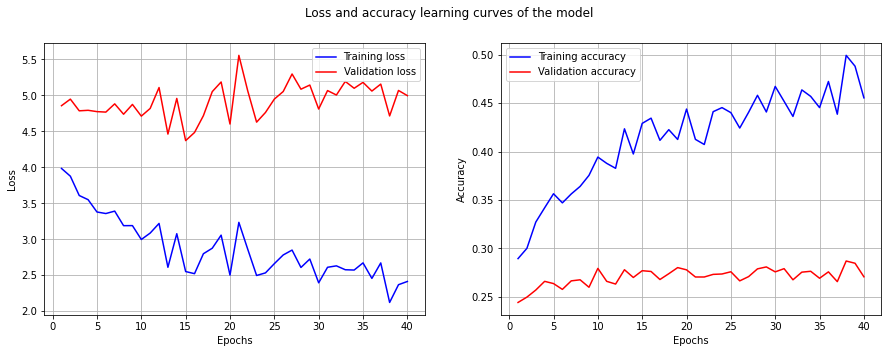

In [865]:
plot_learning_curve(epochs_1, loss_train_1, acc_train_1, loss_val_1, acc_val_1)

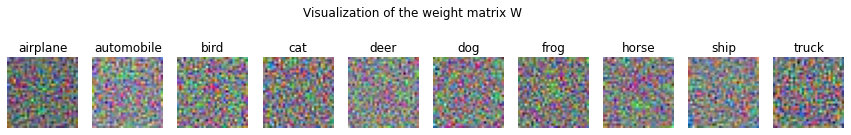

In [866]:
plot_weights(W_1, label_names)

#### Evaluating performance on test data

In [867]:
loss_test = ComputeCost(X_test, Y_t, W_1, b_1, λ_1)
acc_test = ComputeAccuracy(X_test, y_t, W_1, b_1)

print("Test loss: ", loss_test)
print("Test accuracy: ", acc_test)

Test loss:  4.975672495830973
Test accuracy:  0.2727


#### Training the model with 2nd set of parameters

In [868]:
# Model parameters 2
GDparams_2 = {'n_batch':100, 'eta':0.001, 'n_epochs':40}
λ_2 = 0

# Training the model
W_2, b_2, epochs_2, loss_train_2, acc_train_2, loss_val_2, acc_val_2 = MiniBatchGD(X = X_train, Y = Y_1, y = y_1, 
                                                                            X_val = X_val, Y_val = Y_2, y_val = y_2,
                                                                            W = W, b = b, GDparams = GDparams_2, λ = λ_2)

  2%|▎         | 1/40 [00:00<00:08,  4.42it/s]

Epoch 1: loss=1.9679794283738248, accuracy=0.2862


  5%|▌         | 2/40 [00:00<00:08,  4.58it/s]

Epoch 2: loss=1.8875049143916152, accuracy=0.3287


  8%|▊         | 3/40 [00:00<00:08,  4.33it/s]

Epoch 3: loss=1.8457682160050302, accuracy=0.3507


 10%|█         | 4/40 [00:00<00:08,  4.39it/s]

Epoch 4: loss=1.8182188098362553, accuracy=0.3658


 12%|█▎        | 5/40 [00:01<00:07,  4.45it/s]

Epoch 5: loss=1.7976836480143585, accuracy=0.377


 15%|█▌        | 6/40 [00:01<00:07,  4.45it/s]

Epoch 6: loss=1.7812316102100512, accuracy=0.3855


 18%|█▊        | 7/40 [00:01<00:07,  4.38it/s]

Epoch 7: loss=1.7674261582886812, accuracy=0.3919


 20%|██        | 8/40 [00:01<00:07,  4.43it/s]

Epoch 8: loss=1.7554735563892514, accuracy=0.3966


 22%|██▎       | 9/40 [00:02<00:06,  4.45it/s]

Epoch 9: loss=1.7448950274127875, accuracy=0.4006


 25%|██▌       | 10/40 [00:02<00:06,  4.37it/s]

Epoch 10: loss=1.7353812922581444, accuracy=0.4037


 28%|██▊       | 11/40 [00:02<00:06,  4.32it/s]

Epoch 11: loss=1.7267211701231284, accuracy=0.4079


 30%|███       | 12/40 [00:02<00:06,  4.21it/s]

Epoch 12: loss=1.7187637312864328, accuracy=0.4127


 32%|███▎      | 13/40 [00:02<00:06,  4.28it/s]

Epoch 13: loss=1.7113969531786173, accuracy=0.4161


 35%|███▌      | 14/40 [00:03<00:06,  4.27it/s]

Epoch 14: loss=1.7045350405547401, accuracy=0.4188


 38%|███▊      | 15/40 [00:03<00:05,  4.35it/s]

Epoch 15: loss=1.6981105467075952, accuracy=0.4209


 40%|████      | 16/40 [00:03<00:05,  4.24it/s]

Epoch 16: loss=1.6920692810946847, accuracy=0.4217


 42%|████▎     | 17/40 [00:03<00:05,  4.25it/s]

Epoch 17: loss=1.6863669011008293, accuracy=0.4233


 45%|████▌     | 18/40 [00:04<00:05,  4.25it/s]

Epoch 18: loss=1.680966559137385, accuracy=0.4257


 48%|████▊     | 19/40 [00:04<00:04,  4.28it/s]

Epoch 19: loss=1.6758372328523656, accuracy=0.4279


 50%|█████     | 20/40 [00:04<00:04,  4.22it/s]

Epoch 20: loss=1.6709525106500274, accuracy=0.4306


 52%|█████▎    | 21/40 [00:04<00:04,  4.24it/s]

Epoch 21: loss=1.6662896888322074, accuracy=0.4341


 55%|█████▌    | 22/40 [00:05<00:04,  4.15it/s]

Epoch 22: loss=1.6618290871977965, accuracy=0.4354


 57%|█████▊    | 23/40 [00:05<00:04,  4.15it/s]

Epoch 23: loss=1.6575535211529586, accuracy=0.4368


 60%|██████    | 24/40 [00:05<00:03,  4.14it/s]

Epoch 24: loss=1.6534478881792896, accuracy=0.4393


 62%|██████▎   | 25/40 [00:05<00:03,  4.20it/s]

Epoch 25: loss=1.6494988393635268, accuracy=0.4411


 65%|██████▌   | 26/40 [00:06<00:03,  4.12it/s]

Epoch 26: loss=1.6456945152281892, accuracy=0.4423


 68%|██████▊   | 27/40 [00:06<00:03,  4.09it/s]

Epoch 27: loss=1.642024330889345, accuracy=0.4434


 70%|███████   | 28/40 [00:06<00:02,  4.07it/s]

Epoch 28: loss=1.6384787995630188, accuracy=0.4454


 72%|███████▎  | 29/40 [00:06<00:02,  4.05it/s]

Epoch 29: loss=1.6350493862508626, accuracy=0.446


 75%|███████▌  | 30/40 [00:07<00:02,  4.00it/s]

Epoch 30: loss=1.631728385442043, accuracy=0.4467


 78%|███████▊  | 31/40 [00:07<00:02,  3.92it/s]

Epoch 31: loss=1.6285088181225311, accuracy=0.4485


 80%|████████  | 32/40 [00:07<00:02,  3.84it/s]

Epoch 32: loss=1.6253843444525278, accuracy=0.4498


 82%|████████▎ | 33/40 [00:07<00:01,  3.89it/s]

Epoch 33: loss=1.6223491892680144, accuracy=0.4523


 85%|████████▌ | 34/40 [00:08<00:01,  3.91it/s]

Epoch 34: loss=1.6193980781627229, accuracy=0.4535


 88%|████████▊ | 35/40 [00:08<00:01,  3.88it/s]

Epoch 35: loss=1.616526182362701, accuracy=0.4549


 90%|█████████ | 36/40 [00:08<00:01,  3.65it/s]

Epoch 36: loss=1.6137290709575551, accuracy=0.4562


 92%|█████████▎| 37/40 [00:08<00:00,  3.60it/s]

Epoch 37: loss=1.611002669324868, accuracy=0.4577


 95%|█████████▌| 38/40 [00:09<00:00,  3.78it/s]

Epoch 38: loss=1.6083432227987078, accuracy=0.4584


 98%|█████████▊| 39/40 [00:09<00:00,  3.81it/s]

Epoch 39: loss=1.6057472648018176, accuracy=0.4602


100%|██████████| 40/40 [00:09<00:00,  4.09it/s]

Epoch 40: loss=1.6032115887963465, accuracy=0.4613


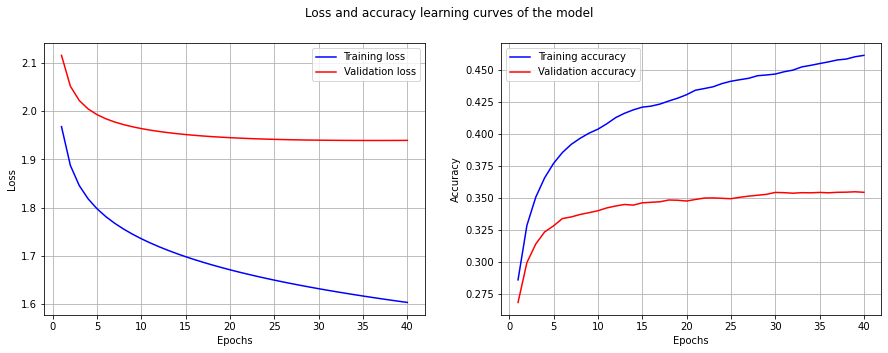

In [869]:
plot_learning_curve(epochs_2, loss_train_2, acc_train_2, loss_val_2, acc_val_2)

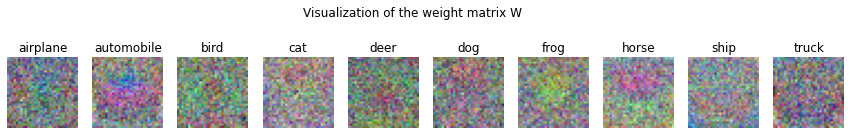

In [870]:
plot_weights(W_2, label_names)

#### Evaluating performance on test data

In [871]:
loss_test = ComputeCost(X_test, Y_t, W_2, b_2, λ_2)
acc_test = ComputeAccuracy(X_test, y_t, W_2, b_2)

print("Test loss: ", loss_test)
print("Test accuracy: ", acc_test)

Test loss:  1.9117692010087748
Test accuracy:  0.3592


#### Training the model with 3rd set of parameters

In [872]:
# Model parameters 3
GDparams_3 = {'n_batch':100, 'eta':0.001, 'n_epochs':40}
λ_3 = 0.1

# Training the model
W_3, b_3, epochs_3, loss_train_3, acc_train_3, loss_val_3, acc_val_3 = MiniBatchGD(X = X_train, Y = Y_1, y = y_1, 
                                                                            X_val = X_val, Y_val = Y_2, y_val = y_2,
                                                                            W = W, b = b, GDparams = GDparams_3, λ = λ_3)

  2%|▎         | 1/40 [00:00<00:11,  3.52it/s]

Epoch 1: loss=2.262118600390609, accuracy=0.2872


  5%|▌         | 2/40 [00:00<00:10,  3.46it/s]

Epoch 2: loss=2.1712477140409177, accuracy=0.3303


  8%|▊         | 3/40 [00:00<00:10,  3.66it/s]

Epoch 3: loss=2.1197946974233077, accuracy=0.3521


 10%|█         | 4/40 [00:01<00:10,  3.58it/s]

Epoch 4: loss=2.0831089017567606, accuracy=0.3673


 12%|█▎        | 5/40 [00:01<00:09,  3.65it/s]

Epoch 5: loss=2.053991878353456, accuracy=0.378


 15%|█▌        | 6/40 [00:01<00:09,  3.74it/s]

Epoch 6: loss=2.029489475135809, accuracy=0.3883


 18%|█▊        | 7/40 [00:01<00:08,  3.67it/s]

Epoch 7: loss=2.008138873744804, accuracy=0.3944


 20%|██        | 8/40 [00:02<00:08,  3.64it/s]

Epoch 8: loss=1.9891182282660087, accuracy=0.3993


 22%|██▎       | 9/40 [00:02<00:08,  3.75it/s]

Epoch 9: loss=1.9719203481616354, accuracy=0.4031


 25%|██▌       | 10/40 [00:02<00:07,  3.78it/s]

Epoch 10: loss=1.9562082450083298, accuracy=0.4066


 28%|██▊       | 11/40 [00:03<00:07,  3.66it/s]

Epoch 11: loss=1.9417443123493507, accuracy=0.4104


 30%|███       | 12/40 [00:03<00:07,  3.60it/s]

Epoch 12: loss=1.9283527675504124, accuracy=0.4135


 32%|███▎      | 13/40 [00:03<00:07,  3.59it/s]

Epoch 13: loss=1.9158984126747511, accuracy=0.4165


 35%|███▌      | 14/40 [00:03<00:07,  3.58it/s]

Epoch 14: loss=1.9042739485523894, accuracy=0.4186


 38%|███▊      | 15/40 [00:04<00:07,  3.55it/s]

Epoch 15: loss=1.893392027201298, accuracy=0.4213


 40%|████      | 16/40 [00:04<00:06,  3.54it/s]

Epoch 16: loss=1.8831800585387655, accuracy=0.4236


 42%|████▎     | 17/40 [00:04<00:06,  3.51it/s]

Epoch 17: loss=1.8735766878434947, accuracy=0.4248


 45%|████▌     | 18/40 [00:05<00:06,  3.40it/s]

Epoch 18: loss=1.8645293262457134, accuracy=0.4272


 48%|████▊     | 19/40 [00:05<00:06,  3.46it/s]

Epoch 19: loss=1.8559923682526898, accuracy=0.4298


 50%|█████     | 20/40 [00:05<00:05,  3.52it/s]

Epoch 20: loss=1.847925871751149, accuracy=0.4306


 52%|█████▎    | 21/40 [00:05<00:05,  3.54it/s]

Epoch 21: loss=1.8402945582354624, accuracy=0.432


 55%|█████▌    | 22/40 [00:06<00:05,  3.50it/s]

Epoch 22: loss=1.8330670404749658, accuracy=0.4331


 57%|█████▊    | 23/40 [00:06<00:04,  3.60it/s]

Epoch 23: loss=1.8262152154526041, accuracy=0.4344


 60%|██████    | 24/40 [00:06<00:04,  3.72it/s]

Epoch 24: loss=1.8197137798872547, accuracy=0.436


 62%|██████▎   | 25/40 [00:06<00:04,  3.68it/s]

Epoch 25: loss=1.8135398383625745, accuracy=0.4375


 65%|██████▌   | 26/40 [00:07<00:03,  3.68it/s]

Epoch 26: loss=1.8076725825753281, accuracy=0.4383


 68%|██████▊   | 27/40 [00:07<00:03,  3.78it/s]

Epoch 27: loss=1.8020930260126193, accuracy=0.4402


 70%|███████   | 28/40 [00:07<00:03,  3.75it/s]

Epoch 28: loss=1.7967837824025745, accuracy=0.4409


 72%|███████▎  | 29/40 [00:08<00:02,  3.71it/s]

Epoch 29: loss=1.7917288791469772, accuracy=0.4422


 75%|███████▌  | 30/40 [00:08<00:02,  3.69it/s]

Epoch 30: loss=1.7869135990095317, accuracy=0.4422


 78%|███████▊  | 31/40 [00:08<00:02,  3.76it/s]

Epoch 31: loss=1.7823243448480495, accuracy=0.4429


 80%|████████  | 32/40 [00:08<00:02,  3.80it/s]

Epoch 32: loss=1.7779485233041332, accuracy=0.4435


 82%|████████▎ | 33/40 [00:09<00:01,  3.76it/s]

Epoch 33: loss=1.7737744442131416, accuracy=0.4448


 85%|████████▌ | 34/40 [00:09<00:01,  3.71it/s]

Epoch 34: loss=1.7697912331435133, accuracy=0.4466


 88%|████████▊ | 35/40 [00:09<00:01,  3.81it/s]

Epoch 35: loss=1.765988754974932, accuracy=0.4473


 90%|█████████ | 36/40 [00:09<00:01,  3.74it/s]

Epoch 36: loss=1.7623575468133383, accuracy=0.4485


 92%|█████████▎| 37/40 [00:10<00:00,  3.73it/s]

Epoch 37: loss=1.7588887588478836, accuracy=0.4498


 95%|█████████▌| 38/40 [00:10<00:00,  3.81it/s]

Epoch 38: loss=1.755574101998366, accuracy=0.4499


 98%|█████████▊| 39/40 [00:10<00:00,  3.83it/s]

Epoch 39: loss=1.7524058013962143, accuracy=0.4506


100%|██████████| 40/40 [00:10<00:00,  3.67it/s]

Epoch 40: loss=1.749376554900446, accuracy=0.4519


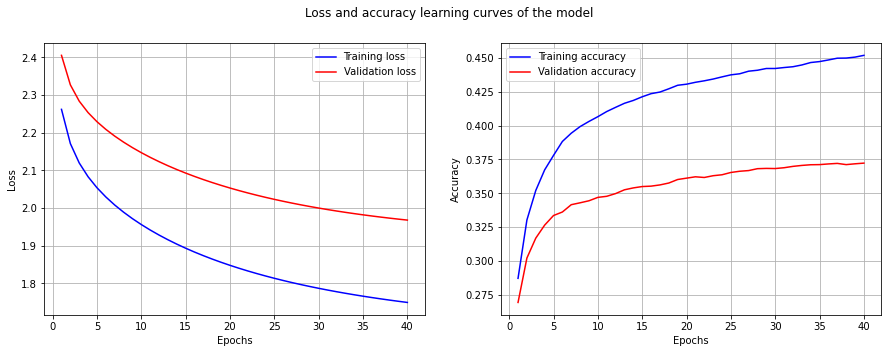

In [873]:
plot_learning_curve(epochs_3, loss_train_3, acc_train_3, loss_val_3, acc_val_3)

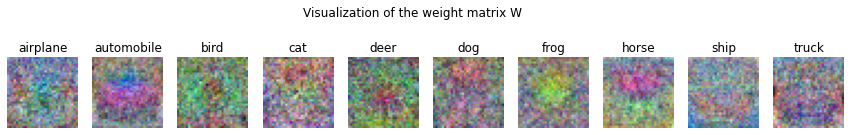

In [874]:
plot_weights(W_3, label_names)

#### Evaluating performance on test data

In [875]:
loss_test = ComputeCost(X_test, Y_t, W_3, b_3, λ_3)
acc_test = ComputeAccuracy(X_test, y_t, W_3, b_3)

print("Test loss: ", loss_test)
print("Test accuracy: ", acc_test)

Test loss:  1.9471666432105512
Test accuracy:  0.3762


#### Training the model with 4th set of parameters

In [876]:
# Model parameters 4
GDparams_4 = {'n_batch':100, 'eta':0.001, 'n_epochs':40}
λ_4 = 1

# Training the model
W_4, b_4, epochs_4, loss_train_4, acc_train_4, loss_val_4, acc_val_4 = MiniBatchGD(X = X_1, Y = Y_1, y = y_1, 
                                                                            X_val = X_2, Y_val = Y_2, y_val = y_2,
                                                                            W = W, b = b, GDparams = GDparams_4, λ = λ_4)

  2%|▎         | 1/40 [00:00<00:10,  3.73it/s]

Epoch 1: loss=4.025167678823857, accuracy=0.2954


  5%|▌         | 2/40 [00:00<00:09,  3.85it/s]

Epoch 2: loss=3.2886323197565233, accuracy=0.3421


  8%|▊         | 3/40 [00:00<00:09,  3.73it/s]

Epoch 3: loss=2.814888534921676, accuracy=0.3631


 10%|█         | 4/40 [00:01<00:09,  3.66it/s]

Epoch 4: loss=2.503381919176537, accuracy=0.3743


 12%|█▎        | 5/40 [00:01<00:09,  3.62it/s]

Epoch 5: loss=2.2970780958920187, accuracy=0.3819


 15%|█▌        | 6/40 [00:01<00:09,  3.43it/s]

Epoch 6: loss=2.159993751408934, accuracy=0.3874


 18%|█▊        | 7/40 [00:02<00:09,  3.31it/s]

Epoch 7: loss=2.0687318764218086, accuracy=0.3921


 20%|██        | 8/40 [00:02<00:10,  3.20it/s]

Epoch 8: loss=2.0078982201039257, accuracy=0.395


 22%|██▎       | 9/40 [00:02<00:09,  3.22it/s]

Epoch 9: loss=1.967306606368821, accuracy=0.3969


 25%|██▌       | 10/40 [00:02<00:09,  3.15it/s]

Epoch 10: loss=1.940196199122355, accuracy=0.3984


 28%|██▊       | 11/40 [00:03<00:09,  3.16it/s]

Epoch 11: loss=1.9220713573999173, accuracy=0.3989


 30%|███       | 12/40 [00:03<00:08,  3.19it/s]

Epoch 12: loss=1.9099391050320116, accuracy=0.4001


 32%|███▎      | 13/40 [00:03<00:08,  3.22it/s]

Epoch 13: loss=1.901805210335048, accuracy=0.4001


 35%|███▌      | 14/40 [00:04<00:08,  3.13it/s]

Epoch 14: loss=1.8963401001452098, accuracy=0.4004


 38%|███▊      | 15/40 [00:04<00:07,  3.24it/s]

Epoch 15: loss=1.892656921471633, accuracy=0.4008


 40%|████      | 16/40 [00:04<00:07,  3.35it/s]

Epoch 16: loss=1.890163904737077, accuracy=0.4017


 42%|████▎     | 17/40 [00:05<00:06,  3.32it/s]

Epoch 17: loss=1.8884660595275462, accuracy=0.4022


 45%|████▌     | 18/40 [00:05<00:06,  3.35it/s]

Epoch 18: loss=1.887299672097916, accuracy=0.4024


 48%|████▊     | 19/40 [00:05<00:05,  3.51it/s]

Epoch 19: loss=1.8864886356525163, accuracy=0.4026


 50%|█████     | 20/40 [00:05<00:05,  3.52it/s]

Epoch 20: loss=1.8859153236241573, accuracy=0.4026


 52%|█████▎    | 21/40 [00:06<00:05,  3.54it/s]

Epoch 21: loss=1.8855011559057766, accuracy=0.402


 55%|█████▌    | 22/40 [00:06<00:04,  3.63it/s]

Epoch 22: loss=1.8851936285098034, accuracy=0.4019


 57%|█████▊    | 23/40 [00:06<00:04,  3.72it/s]

Epoch 23: loss=1.884957654811379, accuracy=0.4019


 60%|██████    | 24/40 [00:07<00:04,  3.66it/s]

Epoch 24: loss=1.884769783860232, accuracy=0.4017


 62%|██████▎   | 25/40 [00:07<00:04,  3.65it/s]

Epoch 25: loss=1.8846143390502201, accuracy=0.4017


 65%|██████▌   | 26/40 [00:07<00:03,  3.75it/s]

Epoch 26: loss=1.884480838871432, accuracy=0.4018


 68%|██████▊   | 27/40 [00:07<00:03,  3.71it/s]

Epoch 27: loss=1.884362273791396, accuracy=0.402


 70%|███████   | 28/40 [00:08<00:03,  3.62it/s]

Epoch 28: loss=1.8842539549318054, accuracy=0.402


 72%|███████▎  | 29/40 [00:08<00:02,  3.74it/s]

Epoch 29: loss=1.8841527447010735, accuracy=0.4022


 75%|███████▌  | 30/40 [00:08<00:02,  3.73it/s]

Epoch 30: loss=1.88405654260771, accuracy=0.4026


 78%|███████▊  | 31/40 [00:08<00:02,  3.43it/s]

Epoch 31: loss=1.8839639415798266, accuracy=0.4028


 80%|████████  | 32/40 [00:09<00:02,  3.37it/s]

Epoch 32: loss=1.8838739982272368, accuracy=0.4024


 82%|████████▎ | 33/40 [00:09<00:02,  3.45it/s]

Epoch 33: loss=1.8837860792548011, accuracy=0.4024


 85%|████████▌ | 34/40 [00:09<00:01,  3.51it/s]

Epoch 34: loss=1.8836997587756965, accuracy=0.4022


 88%|████████▊ | 35/40 [00:10<00:01,  3.33it/s]

Epoch 35: loss=1.88361474964965, accuracy=0.4023


 90%|█████████ | 36/40 [00:10<00:01,  3.00it/s]

Epoch 36: loss=1.8835308575676823, accuracy=0.402


 92%|█████████▎| 37/40 [00:10<00:00,  3.05it/s]

Epoch 37: loss=1.8834479503451116, accuracy=0.4018


 95%|█████████▌| 38/40 [00:11<00:00,  3.13it/s]

Epoch 38: loss=1.88336593738328, accuracy=0.4018


 98%|█████████▊| 39/40 [00:11<00:00,  3.18it/s]

Epoch 39: loss=1.883284755931447, accuracy=0.4018


100%|██████████| 40/40 [00:11<00:00,  3.39it/s]

Epoch 40: loss=1.88320436189598, accuracy=0.4018


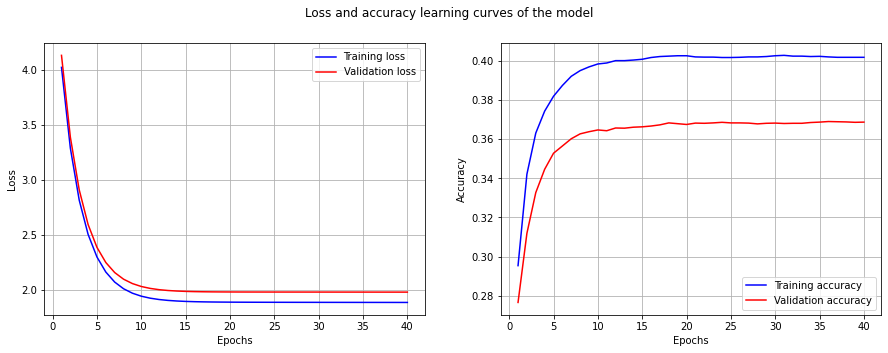

In [877]:
plot_learning_curve(epochs_4, loss_train_4, acc_train_4, loss_val_4, acc_val_4)

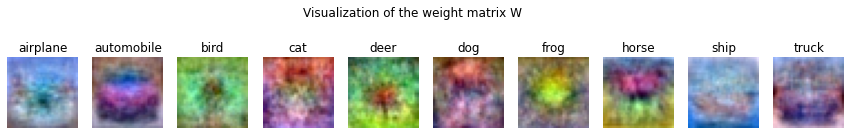

In [878]:
plot_weights(W_4, label_names)

#### Evaluating performance on test data

In [879]:
loss_test = ComputeCost(X_test, Y_t, W_4, b_4, λ_4)
acc_test = ComputeAccuracy(X_test, y_t, W_4, b_4)

print("Test loss: ", loss_test)
print("Test accuracy: ", acc_test)

Test loss:  1.9630561397413173
Test accuracy:  0.367
